In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import load_data as ld
from tensorflow import keras
from sklearn.utils import shuffle
from tensorflow.keras import datasets, layers, models
print(tf.__version__)

2.6.0


In [2]:
ip_data = np.load("../data/htmp_data/all_net_ip_data.npy")
out_data = np.load("../data/htmp_data/all_net_out_data.npy")
ip_data.shape,out_data.shape

((39, 24, 72, 6), (39, 17))

In [3]:
model = keras.models.load_model("../data/model/exp2_pretrain")


In [4]:
pre_data = model.predict(ip_data[[8]])

In [5]:
pre_data

array([[-0.36990306, -1.1406609 , -1.048283  , -1.5720191 , -1.6421947 ,
        -1.6497418 , -1.6231589 , -1.6164821 , -1.6070056 , -1.4601748 ,
        -0.9387852 , -1.3288542 , -0.7200148 , -0.6053281 , -0.18441728,
        -0.6529384 , -0.3971004 ]], dtype=float32)

In [8]:
out_data[8,:]

array([-0.20080908, -0.75643605, -1.0901551 , -1.2426001 , -1.2137023 ,
       -1.4000775 , -1.636279  , -1.8660755 , -1.8482633 , -1.6232814 ,
       -1.400351  , -1.1183982 , -0.8985808 , -0.685791  , -0.47397125,
       -0.421023  , -0.33048812], dtype=float32)

DatetimeIndex(['1988-04-01', '1988-05-01', '1988-06-01', '1988-07-01',
               '1988-08-01', '1988-09-01', '1988-10-01', '1988-11-01',
               '1988-12-01', '1989-01-01', '1989-02-01', '1989-03-01',
               '1989-04-01', '1989-05-01', '1989-06-01', '1989-07-01',
               '1989-08-01'],
              dtype='datetime64[ns]', freq='MS')


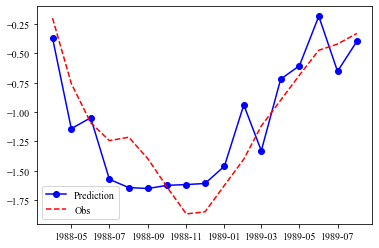

In [9]:
import pandas as pd
plt.rc('font', family='Times New Roman')
time0 = pd.date_range("1988-04-01","1989-08-15",freq="MS")
print(time0)
plt.plot(time0,pre_data[0],"o-",color="blue",label="Prediction")
plt.plot(time0,out_data[8],"--",color="red",label="Obs")
plt.legend()
plt.savefig("../pic/1988_la.png")

In [10]:
last_conv_layer_name = "conv2d_2"
grad_model = tf.keras.models.Model(
    [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
)
grad_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_input (InputLayer)    [(None, 24, 72, 6)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 24, 72, 50)        9650      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 12, 36, 50)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 12, 36, 50)        80050     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 6, 18, 50)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 6, 18, 50)         80050     
_________________________________________________________________
flatten (Flatten)            (None, 5400)              0     

In [11]:
with tf.GradientTape() as tape:
    last_conv_layer_output, preds = grad_model(ip_data[[8]])
    class_channel = preds[:,9]
grads = tape.gradient(class_channel, last_conv_layer_output)
grads.shape,preds.shape

(TensorShape([1, 6, 18, 50]), TensorShape([1, 17]))

In [12]:
pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
# pooled_grads = grads
pooled_grads.shape

TensorShape([50])

In [13]:
last_conv_layer_output = last_conv_layer_output[0]
last_conv_layer_output.shape

TensorShape([6, 18, 50])

In [14]:
heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]

In [15]:
heatmap = tf.squeeze(heatmap)

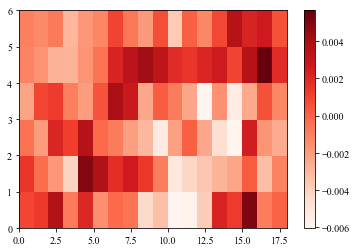

In [16]:
plt.pcolor(heatmap,cmap="Reds")
plt.colorbar()

In [17]:
lon = np.arange(0,356,5,dtype=float)
lat = np.arange(-55,61,5,dtype=float)

In [18]:
LON,LAT = np.meshgrid(lon,lat)

In [19]:
map_fun = keras.layers.AveragePooling2D((2,2))

In [20]:
lat1 = map_fun(map_fun(LAT[np.newaxis,:,:,np.newaxis]))[0,:,:,0]
lon1 = map_fun(map_fun(LON[np.newaxis,:,:,np.newaxis]))[0,:,:,0]

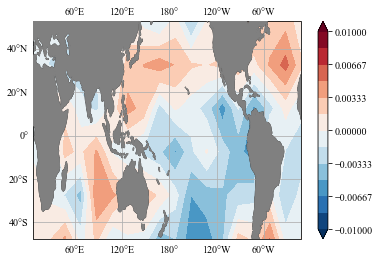

In [22]:
from tensorflow.python.ops.numpy_ops import np_config
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cft
np_config.enable_numpy_behavior()
ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=180))
m = ax.contourf(lon1,lat1,heatmap,cmap="RdBu_r",
    transform=ccrs.PlateCarree(),levels=np.linspace(-0.01,0.01,13),
    extend="both")
plt.colorbar(m)
ax.set_aspect("auto")
ax.coastlines()
ax.add_feature(cft.LAND,color="gray",zorder=10)
ax.gridlines(draw_labels=True)

In [23]:
np.save("../data/htmp_data/lon1",lon1)
np.save("../data/htmp_data/lat1",lat1)
np.save("../data/htmp_data/1988lanina2",heatmap)

In [24]:
model.layers[-1].get_weights()[-1][6]

0.0053822417